# Assignment 4

Deadline: 30.04.2025 12:00 CET

Niall Kelly, 24-743-601

Matej Mijatovic, 20-454-773

Christopher Yuan, 24-746-059

Kilian Picinali, 20-993-515

Yannick Secchi, 19-451-046

## Prerequisites: Library imports, data load and initialization of the backtest service

In [1]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

# custom imports
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar

In [2]:
# Load data
path_to_data = '../data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>

In [3]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [4]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [5]:
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 iters: int = 10,
                 risk_aversion: float = 1.0,
                 turnover_penalty: float = 0.0,
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return
        self.iters = iters
        self.params['risk_aversion'] = risk_aversion
        self.params['turnover_penalty'] = turnover_penalty

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.data = optimization_data
        X = optimization_data['return_series']
        self.covmat = self.covariance.estimate(X=X, inplace=False)
        self.mu  = self.expected_return.estimate(X=X, inplace=False)
        self.objective = Objective(
            q = self.mu * -1,
            P = self.covmat * 2 * self.params['risk_aversion'],
        )

        self.og_P = (2 * self.covmat).copy()
        return None

    def solve(self) -> None:
        
        # opimization function
        def mean_var_solver(a):
            self.params['risk_aversion'] = a[0]
            self.objective.coefficients['P'] = self.og_P * a[0]
            super(MaxSharpe, self).solve()
            w = np.array(list(self.results['weights'].values()))
            sharpe = (self.mu @ w) / np.sqrt(w @ self.covmat @ w)
            return sharpe

        sharpe_maximization = minimize(
        fun=lambda x: -1.0*mean_var_solver(x),
        x0=np.array([1.0]),
        bounds=[(1e-2, 1e2)],
        method="Powell",
        tol = 1e-3,
        options={"maxiter": self.iters}
        )

        # getting results
        optimal_ra = (sharpe_maximization.x)[0]
        optimal_sr = -1*sharpe_maximization.fun
        self.params['risk_aversion'] = optimal_ra
        self.objective.coefficients['P'] = self.og_P * optimal_ra
        super().solve()
        optimal_w = self.results['weights']

        # storing results
        self.results = {
            'risk_aversion': optimal_ra,
            'sharpe_ratio': optimal_sr,
            'weights': optimal_w
        }

        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In the above we used Scipy.optimize.minimize which works well on multidimensional problems but also 1D problems as in our case. We specify that we want to use the Powell algorithm. When applied to a 1D problem, this algorithm will employ either a Golden-section search or Brent's method. These are two well known optmization procedures that have a lot of theoretical underpinning.

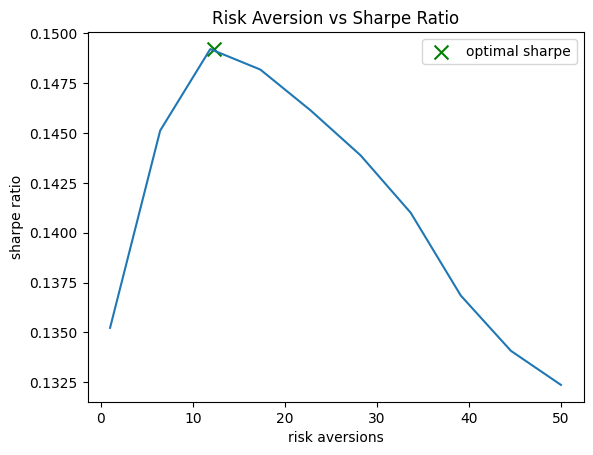

In [10]:
ra_grid = np.linspace(1, 50, 10)
sr_array = []

bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',  # <change this to your preferred solver>
    iters = 10,
    risk_aversion = 1.0
    )
bs.prepare_rebalancing('2015-01-02')
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
optimal_res = bs.optimization.results
optimal_sr = optimal_res['sharpe_ratio']
optimal_ra = optimal_res['risk_aversion']

for ra in ra_grid:
    bs.optimization = MeanVariance(
        covariance=Covariance(method='pearson'),
        expected_return=ExpectedReturn(method='geometric'),
        solver_name = 'cvxopt',
        risk_aversion = ra)
    bs.prepare_rebalancing('2015-01-02')
    bs.optimization.set_objective(bs.optimization_data)
    bs.optimization.solve()
    weights = np.array(list(bs.optimization.results["weights"].values()))
    mu = -bs.optimization.objective.coefficients["q"]
    cov = bs.optimization.objective.coefficients["P"]/(2*ra)
    sr_array.append(mu@weights/np.sqrt(weights@cov@weights))

plt.plot(ra_grid, sr_array)
plt.scatter([optimal_ra], [optimal_sr], marker='x', color='green', s=100, label = 'optimal sharpe')
plt.xlabel('risk aversions')
plt.ylabel('sharpe ratio')
plt.title('Risk Aversion vs Sharpe Ratio')
plt.legend()
plt.show()

Here we can see through this crude plot that our computed maximum is the true maxium.

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [9]:
tol = 0.05 # tolerance
iter_count = 0 # iteration of refinement count
max_iter = 3 # max number of refinements
to_array = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]


best_to = None # best turnover
best_annual_to = None # the annual turnover best_to achieves

my_bool = True

while my_bool:
    errors = []
    print('turnover penalty array is',to_array)
    for i in range((len(to_array))):
        to = to_array[i]
        bs.optimization = MaxSharpe(
            covariance = Covariance(method='pearson'),
            expected_return = ExpectedReturn(method='geometric'),
            solver_name = 'cvxopt',    # <change this to your preferred solver>
            turnover_penalty= to,   # <change this>
            )

        # Instantiate the backtest object
        bt_ms = Backtest()

        # Run the backtest
        bt_ms.run(bs = bs)

        annual_to = bt_ms.strategy.turnover(return_series = bs.data.get_return_series()).mean() * 4

        errors.append(abs(annual_to - 1.0))

        print(f'for index {i} and to {to} our annual turnover is {annual_to} with error {errors[i]}')

        if errors[i] < tol:
            best_to = to_array[i]
            best_annual_to = annual_to
            my_bool = False
            break

        elif (i>1) and (errors[i]>errors[i-1]):
            to_array = np.linspace(to_array[i-2], to_array[i], 7)[1:-1]
            break
    iter_count += 1
    if iter_count >= max_iter:
        break
     
print('best penalty = ',best_to)
print('annual turover achieved with this penalty = ',best_annual_to)

turnover penalty array is [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005]
Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
R

In [12]:
## running again for use in the final question

bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=0.0001,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


c:\Users\njkel\OneDrive\Documents\Zurich_University\UZH\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Users\njkel\OneDrive\Documents\Zurich_University\UZH\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


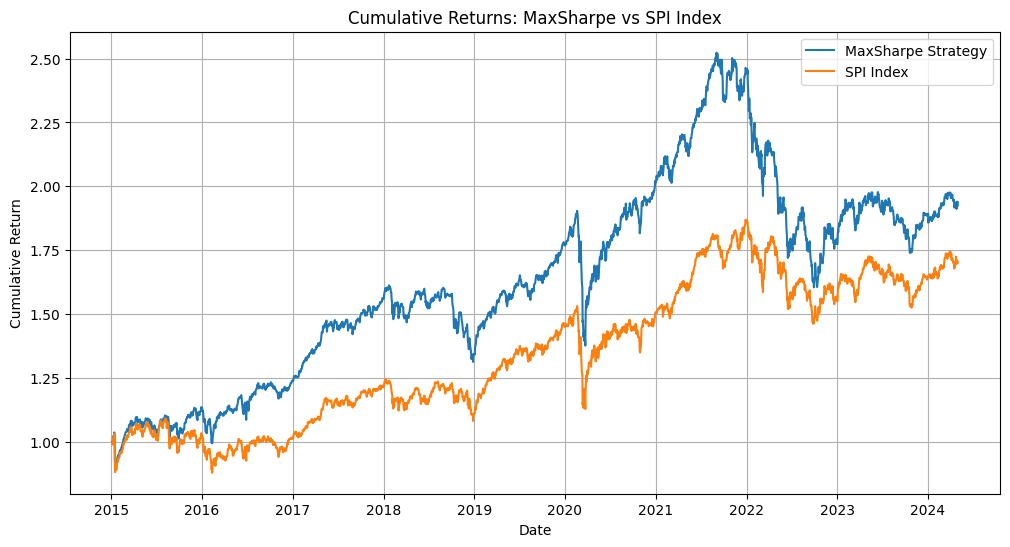

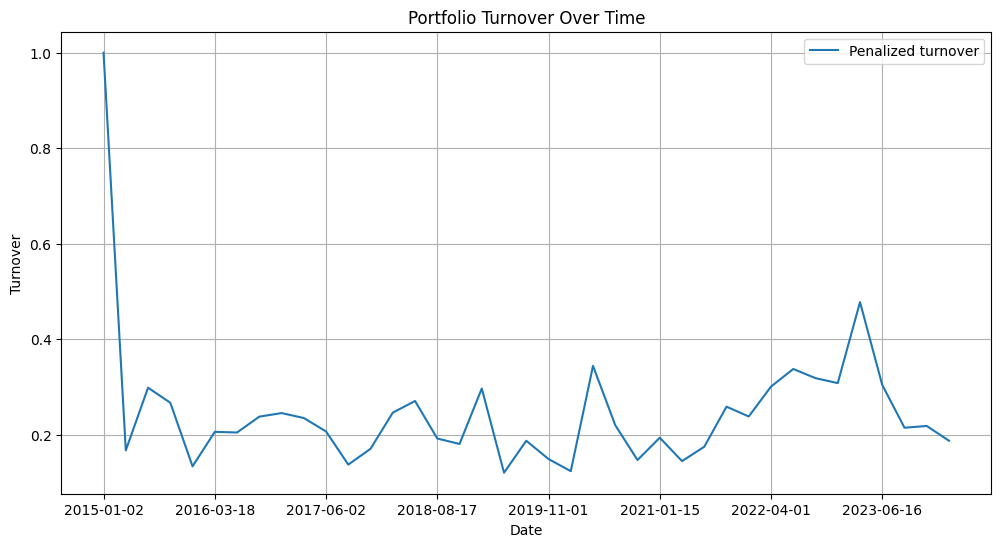

Annualized Turnover: 99.14%

Key Performance Statistics:
                   MaxSharpe Strategy SPI Index
Annual Return                0.070186  0.056593
Volatility                   0.142063   0.14569
Sharpe Ratio                 0.494047   0.38845
Sortino Ratio                0.597302   0.47793
Max Drawdown                -0.364073 -0.263289
Tracking Error               0.070131       N/A
Beta                         0.859908       N/A
Alpha                        0.161613       N/A
Information Ratio            2.304438       N/A


In [13]:
# Align return series for all assets in portfolios
asset_ids = list(set().union(*[set(p.weights.keys()) for p in bt_ms.strategy.portfolios]))
return_series = bs.data.get_return_series(ids=asset_ids, fillna_value=0)
benchmark_returns = bs.data.bm_series

# Simulate with transaction costs
strategy_returns = bt_ms.strategy.simulate(
    return_series=return_series,
    fc=0.01,    # 1% fixed costs
    vc=0.003,   # 0.3% variable costs
)

# Align strategy and benchmark returns for fair comparison
aligned = pd.concat({'MaxSharpe': strategy_returns, 'SPI': benchmark_returns}, axis=1).dropna()
strategy_returns = aligned['MaxSharpe']
benchmark_returns = aligned['SPI']

# -- Plotting cumulative returns --
plt.figure(figsize=(12, 6))
plt.plot(strategy_returns.index, (1 + strategy_returns).cumprod(), label='MaxSharpe Strategy')
plt.plot(benchmark_returns.index, (1 + benchmark_returns).cumprod(), label='SPI Index')
plt.title('Cumulative Returns: MaxSharpe vs SPI Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and plot turnover
# Retrieving turnover of strategy
to_mv = bt_ms.strategy.turnover(return_series=return_series)

to_df = pd.concat({'mv': to_mv}, axis = 1).dropna()
to_df.columns = ['Penalized turnover']


# -- Plotting turnover --
to_df.plot(figsize=(12, 6))
plt.title('Portfolio Turnover Over Time')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.grid(True)
plt.show()

# -- Printing annualized turnover --
freq = 4 # Quaterly rebalancings
annualized_to = to_df.mean().item() * freq
print(f"Annualized Turnover: {annualized_to:.2%}")


# Key Performance Statistics
def calculate_key_stats(returns, benchmark=None):
    # Basic returns
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252/len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    
    # Risk-adjusted returns
    sharpe_ratio = annualized_return / volatility if volatility > 0 else np.nan
    wealth = (1 + returns).cumprod()
    max_drawdown = ((wealth - wealth.cummax()) / wealth.cummax()).min()
    
    # Sortino Ratio
    downside_deviation = returns[returns < 0].std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_deviation if downside_deviation > 0 else np.nan

    # Relative performance (if benchmark provided)
    if benchmark is not None:
        excess_returns = returns - benchmark
        tracking_error = excess_returns.std() * np.sqrt(252)
        beta = np.cov(returns, benchmark)[0,1] / np.var(benchmark)
        alpha = annualized_return - (beta * (1 + benchmark).prod()**(252/len(benchmark)) - 1)
        info_ratio = alpha / tracking_error if tracking_error > 0 else np.nan
        return {
            'Annual Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'Tracking Error': tracking_error,
            'Beta': beta,
            'Alpha': alpha,
            'Information Ratio': info_ratio
        }
    else:
        return {
            'Annual Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown
        }

# Calculate and display statistics
strategy_stats = calculate_key_stats(strategy_returns, benchmark_returns)
benchmark_stats = calculate_key_stats(benchmark_returns)

stats_df = pd.DataFrame({
    'MaxSharpe Strategy': strategy_stats,
    'SPI Index': benchmark_stats
})

print("\nKey Performance Statistics:")
print(stats_df.fillna('N/A'))